In [1]:
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Utility functions

In [3]:
data_dir = 'C:\\Users\qxu\Study\data\mnist\\'
def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy


def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy


def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels


def prepare_data(random_seed=100):
    np.random.seed(random_seed) # for reproducibility
    trainData, trainLabels = readData(data_dir + 'images_train.csv', data_dir + 'labels_train.csv')
    trainLabels = one_hot_labels(trainLabels)
    p = np.random.permutation(60000)
    trainData = trainData[p,:]
    trainLabels = trainLabels[p,:]

    devData = trainData[0:10000,:]
    devLabels = trainLabels[0:10000,:]
    trainData = trainData[10000:,:]
    trainLabels = trainLabels[10000:,:]

    mean = np.mean(trainData)
    std = np.std(trainData)
    trainData = (trainData - mean) / std
    devData = (devData - mean) / std

    testData, testLabels = readData(data_dir + 'images_test.csv', data_dir + 'labels_test.csv')
    testLabels = one_hot_labels(testLabels)
    testData = (testData - mean) / std

    return trainData, trainLabels, devData, devLabels, testData, testLabels

# Implement components of NN

\begin{align*}
\mathrm{softmax}(x)_i = \frac{e^{x_i}}{\sum_j e^{x_j}} = \frac{e^{x_i + c}}{\sum_j e^{x_j + c}} 
\end{align*}

Since adding a constant won't change softmax results, so we remove the maximum of $x$ for numerical stability. Reference of previous work from cs231n: https://github.com/zyxue/stanford-cs231n/blob/master/assignment1/cs231n/classifiers/softmax.py#L65

In [5]:
def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    
    x is of shape: B x K
    B: batch size
    K: number of classes
    """
    ### YOUR CODE HERE
    c = np.max(x, axis=1, keepdims=True)
    numerator = np.exp(x - c)
    denominator = np.sum(numerator, axis=1, keepdims=True)
    s = numerator / denominator
    ### END YOUR CODE
    return s

\begin{align*}
\mathrm{sigmoid}(x)_i &= \frac{1}{1 + e^{-x}} = \frac{e^{x}}{e^{x} + 1}
\end{align*}

For numerical stability, use the 1st equation for positive x, and the 2nd equation for negative x. Reference: https://github.com/zyxue/stanford-cs231n/blob/5727c79970285e19c005b19237ade7412f676a40/assignment3/cs231n/rnn_layers.py#L264

In [6]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    
    x is of shape: B x H
    """
    ### YOUR CODE HERE
    pos_mask = (x >= 0)
    neg_mask = (x < 0)

    # specify dtype! otherwise, it may all becomes zero, this could have different
    # behaviors depending on numpy version
    z = np.zeros_like(x, dtype=float)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])

    top = np.ones_like(x, dtype=float)
    top[neg_mask] = z[neg_mask]
    s = top / (1 + z)
    ### END YOUR CODE
    return s

Forward propagation equations:

\begin{align*}
h &= sigmoid(z_1) = s(z_1) = s(x W_1 + b_1) \\
\hat y &= softmax(z_2) = f(z_2) = f(hW_2 + b_2) \\
J &= CE(y, \hat y) = - \sum_{k=1}^{K} y_k \log{\hat y_k}
\end{align*}

In [7]:
def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    
    data is of shape: B x D
    labels is of shape: B x K
    """
    W1 = params['W1'] # D x H
    b1 = params['b1'] # B x H
    W2 = params['W2'] # H x K
    b2 = params['b2'] # B x K

    ### YOUR CODE HERE
    z1 = data.dot(W1) + b1
    h = sigmoid(z1)
    z2 = h.dot(W2) + b2
    y = softmax(z2)

    loss = - np.multiply(labels, np.log(y + 1e-16)).sum()
    loss /= data.shape[0]
    ### END YOUR CODE
    return h, y, loss

Back propagation equations, I derived and implemented these before from another NN course: https://github.com/zyxue/stanford-cs224n/blob/master/assignment1/q2-Neural-network-basics.ipynb.

\begin{align*}
\delta_1 &= \frac{\partial J}{\partial z_2} = \hat y - y \\
\frac{\partial J}{\partial W_2}  &= \delta_1 \frac{\partial z_2}{\partial W_2} = h^T \delta_1 \\
\frac{\partial J}{\partial b_2}  &=\delta_1 \frac{\partial z_2}{\partial b_2} = \delta_1 \\
\frac{\partial J}{\partial h}  &= \delta_1 \frac{\partial z_2}{\partial h} = \delta_1 W_2^T\\
\delta_2 &= \frac{\partial J}{\partial z_1}  = \frac{\partial J}{\partial h} \sigma'(z_1) =   \delta_1 W_2^T \circ h(1 - h) \\
\frac{\partial J}{\partial W_1} &= \delta_2 \frac{\partial z_1}{\partial W_1} = x^T \delta_2 \\
\frac{\partial J}{\partial b_1} &= \delta_2 \frac{\partial z_1}{\partial b_1} = \delta_2 \\
\end{align*}

In [8]:
def backward_prop(data, labels, params):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    # The gradient calculation has been checked with gradient_check, and should be correct
    h, y, cost = forward_prop(data, labels, params)

    delta_1 = (y - labels) 
    gradW2 = np.dot(h.T, delta_1)
    gradb2 = np.sum(delta_1, axis=0, keepdims=True)
    
    # Note: in the above
    # matrix multiple sums the grad over all samples in the batch
    # but for b: it needs sum up mannually
    
    delta_2 = np.multiply(np.dot(delta_1, W2.T), h * (1 - h))
    gradW1 = np.dot(data.T, delta_2)
    gradb1 = np.sum(delta_2, axis=0, keepdims=True)
    
    lamb = params['lambda']
    if lamb > 0:
        gradW2 += lamb * W2
        gradW1 += lamb * W1
    ### END YOUR CODE

    grad = {}
    # important: normalize by batch size!
    B = data.shape[0]
    grad['W1'] = gradW1 / B
    grad['W2'] = gradW2 / B
    grad['b1'] = gradb1 / B
    grad['b2'] = gradb2 / B

    return grad

In [9]:
def calc_accuracy(y, labels):
    """my own version of calculate accurancy. Acutally, there is a version of
    `compute_accuracy` in the nn_starter.py code already"""
    pred = np.zeros_like(y)
    # this is wrong! keep here for "good memory"
    # pred[:, np.argmax(y, axis=1)] = 1
    # learned from https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
    pred[np.arange(y.shape[0]), np.argmax(y, axis=1)] = 1
    
    res = np.abs((pred - labels)).sum(axis=1)
    acc = res[res == 0].shape[0] / res.shape[0]
    return acc

In [10]:
def update_params(params, grad, learning_rate):
    # It's minus the grad instead of plus!!!
    params['W1'] -= learning_rate * grad['W1']
    params['W2'] -= learning_rate * grad['W2']
    params['b1'] -= learning_rate * grad['b1']
    params['b2'] -= learning_rate * grad['b2']

In [11]:
def nn_train(trainData, trainLabels, devData, devLabels, 
             num_hidden=300, learning_rate=5, batch_size=1000, num_epochs=30,
             reg_strength=0):
    (m, n) = trainData.shape
    params = {}

    ### YOUR CODE HERE
    # rename variables to more intuitive ones
    N = m
    D = n
    K = trainLabels.shape[1]
    H = num_hidden
    B = batch_size
    
    params['W1'] = np.random.standard_normal((n, H))
    params['b1'] = np.zeros((1, H), dtype=float)
    params['W2'] = np.random.standard_normal((num_hidden, K))
    params['b2'] = np.zeros((1, K), dtype=float)
    params['lambda'] = reg_strength
    
    num_iter = int(N / B) # number of iterations per epoch
    tr_loss, tr_metric, dev_loss, dev_metric = [], [], [], []

    for i in range(num_epochs):
        print(i, end=',')
        for j in range(num_iter):
            batch_data = trainData[j * B: (j + 1) * B]
            batch_labels = trainLabels[j * B: (j + 1) * B]
            grad = backward_prop(batch_data, batch_labels, params)
            update_params(params, grad, learning_rate)
       
        _, _y, _cost = forward_prop(trainData, trainLabels, params)
        tr_loss.append(_cost)
        tr_metric.append(calc_accuracy(_y, trainLabels))
        _, _y, _cost = forward_prop(devData, devLabels, params)
        dev_loss.append(_cost)
        dev_metric.append(calc_accuracy(_y, devLabels))
    ### END YOUR CODE
    return params, tr_loss, tr_metric, dev_loss, dev_metric

In [12]:
%time trainData, trainLabels, devData, devLabels, testData, testLabels = prepare_data(random_seed=1000)

Wall time: 39.7 s


# (a) Train without regularization

In [13]:
num_epochs = 30
params, tr_loss, tr_metric, dev_loss, dev_metric = nn_train(
    trainData, trainLabels, devData, devLabels, num_epochs=num_epochs)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,

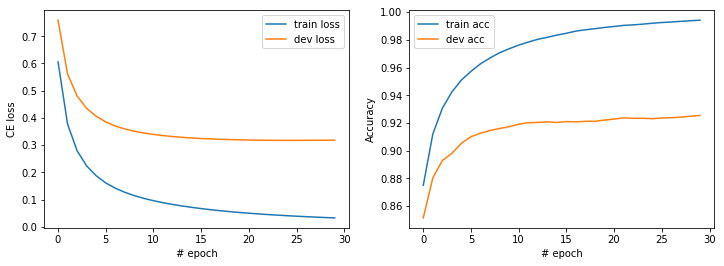

In [14]:
xs = np.arange(num_epochs)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 4))
ax0, ax1 = axes.ravel()

ax0.plot(xs, tr_loss, label='train loss')
ax0.plot(xs, dev_loss, label='dev loss')
ax0.legend()
ax0.set_xlabel('# epoch')
ax0.set_ylabel('CE loss')

ax1.plot(xs, tr_metric, label='train acc')
ax1.plot(xs, dev_metric, label='dev acc')
ax1.legend()
ax1.set_xlabel('# epoch')
ax1.set_ylabel('Accuracy')

# (b) Train with regularization

In [15]:
num_epochs = 30
# tried multiple reg_strength values to pick a relatively good one
params_reg, tr_loss, tr_metric, dev_loss, dev_metric = nn_train(
    trainData, trainLabels, devData, devLabels, num_epochs=num_epochs, reg_strength=0.5)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,

In [16]:
with open('params_with_regularization.pkl', 'wb') as opf:
    pickle.dump(params_reg, opf)

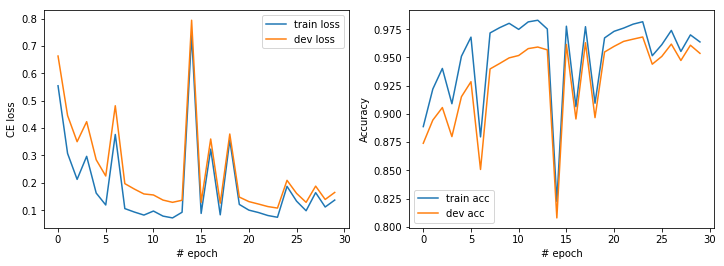

In [17]:
xs = np.arange(num_epochs)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 4))
ax0, ax1 = axes.ravel()

ax0.plot(xs, tr_loss, label='train loss')
ax0.plot(xs, dev_loss, label='dev loss')
ax0.legend()
ax0.set_xlabel('# epoch')
ax0.set_ylabel('CE loss')

ax1.plot(xs, tr_metric, label='train acc')
ax1.plot(xs, dev_metric, label='dev acc')
ax1.legend()
ax1.set_xlabel('# epoch')
ax1.set_ylabel('Accuracy')

**Summary**: without regularization, the overfitting is apparent as there is big difference between the performances on the the training and validation data in terms of both CE loss and accuracy. In contrast, with regularization, the performance on validation data follows that on training data closely, does much better than without regularization. You will see different kinds of spikes by changing the random see when calling `prepare_data`.

# (c) Evaluate performance on the test data

In [18]:
accuracy = nn_test(testData, testLabels, params)
print('Test accuracy (without regularization): {0}'.format(accuracy))

accuracy = nn_test(testData, testLabels, params_reg)
print('Test accuracy (with regularization): {0}'.format(accuracy))

Test accuracy (without regularization): 0.9312
Test accuracy (with regularization): 0.9586
